# Step 1: Minimal Octo Inference Example

This notebook demonstrates how to load a pre-trained / finetuned Octo checkpoint, run inference on some images, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [ ]:
# run this block if you're using Colab

# Download repo
!git clone https://github.com/octo-models/octo.git
%cd octo
# # Install repo
!pip3 install -e .
!pip3 install -r requirements.txt
!pip3 install --upgrade "jax[cuda11_pip]==0.4.20" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install numpy==1.21.1 # to fix colab AttributeError: module 'numpy' has no attribute '_no_nep50_warning', if the error still shows reload

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
from octo.model.octo_model import OctoModel

# model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
model = OctoModel.load_pretrained("/home/yagmurlu/code/octo/logs/octo/octo_pretrain/octo_20240531_213126")

In [ ]:
# the name of the bridge dataset w/ lupus labels is bridge, not bridge dataset
# print(model.dataset_statistics["bridge_dataset"]['action']['mean'])
print(model.dataset_statistics["bridge"]['action']['mean'])

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
# download one example BridgeV2 image
# images are same for the Bridge dataset w/ Lupus labels
IMAGE_URL = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v2/datacol2_toykitchen7/drawer_pnp/01/2023-04-19_09-18-15/raw/traj_group0/traj0/images0/im_12.jpg"
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw).resize((256, 256)))
plt.imshow(img)

In [ ]:
# create obs & task dict, run inference
import jax
# add batch + time horizon 1
img1 = img[np.newaxis,np.newaxis,...]
observation = {"image_primary": img1, "timestep_pad_mask": np.array([[True]])}
task = model.create_tasks(texts=["pick up the fork"])
action = model.sample_actions(
    observation, 
    task, 
    # change the dataset name to bridge
    unnormalization_statistics=model.dataset_statistics["bridge"]["action"], 
    rng=jax.random.PRNGKey(0)
)
print(action)   # [batch, action_chunk, action_dim]

# Step 2: Run Inference on Full Trajectories

That was easy! Now let's try to run inference across a whole trajectory and visualize the results!

In [ ]:
# Install mediapy for visualization
!pip install mediapy
!pip install opencv-python

In [1]:
import cv2
import jax
import tensorflow_datasets as tfds
import tensorflow as tf
import tqdm
import mediapy
import numpy as np

/home/yagmurlu/micromamba/envs/octo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-02 14:51:55.557104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:51:55.557217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:51:55.559154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 14:51:57.232343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warn

## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can specify the path to a checkpoint directory or a HuggingFace path.

Below, we are loading directly from HuggingFace.


In [2]:
from octo.model.octo_model import OctoModel

# model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
model = OctoModel.load_pretrained("/home/yagmurlu/code/octo/logs/octo/octo_pretrain/octo_20240531_213126")

/home/yagmurlu/micromamba/envs/octo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/yagmurlu/micromamba/envs/octo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Load Data
Next, we will load a trajectory from the Bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [17]:
# create RLDS dataset builder
# builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
# ds = builder.as_dataset(split='train[:1]')

builder = tfds.builder_from_directory(builder_dir='/home/marcelr/tensorflow_datasets/bridge/1.0.0/')
ds = builder.as_dataset(split='train[:50]')

# sample episode + resize to 256x256 (default third-person cam resolution)
it = iter(ds)
episode = next(it)
steps = list(episode['steps'])
# # not each sample has lupus labels, so skip empty labels out
while steps[0]['language_instruction'] == "":
    episode = next(it)
    steps = list(episode['steps'])

# instead of image we have image_0 etc for some reason
# images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
images = [cv2.resize(np.array(step['observation']['image_0']), (256, 256)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
# language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()
language_instruction = steps[0]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: Wipe the stove top with the kitchen towel


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [23]:
print(episode['steps'].element_spec)
print(steps[0]['language_instruction'])
print(steps[0]['language_instruction_1'])
print(steps[0]['language_instruction_2'])
print(steps[0]['language_instruction_3'])
print(steps[0]['language_instruction_4'])
print(steps[0]['language_instruction_5'])
print(steps[0]['language_instruction_6'])
print()
print(steps[0]['groundtruth'])

{'action': TensorSpec(shape=(7,), dtype=tf.float64, name=None), 'delta_robot_transform': TensorSpec(shape=(4, 4), dtype=tf.float64, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float64, name=None), 'groundtruth': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_1': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_10': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_11': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_2': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_3': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_4': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_5': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_6': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_7': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_8': TensorSpec(shape=(), dtype=tf.string, name=None), 'groundtruth_9': TensorSpec(shape=(), dtype=tf.string, n

In [24]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [28]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        # unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"], 
        unnormalization_statistics=model.dataset_statistics["bridge"]["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    # true_actions.append(np.concatenate(
    #     (
    #         steps[final_window_step]['action']['world_vector'], 
    #         steps[final_window_step]['action']['rotation_delta'], 
    #         np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
    #     ), axis=-1
    # ))
    true_actions.append(steps[final_window_step]['action'])

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:03<00:00,  6.39it/s]


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

(24, 4, 7)
(24, 7)


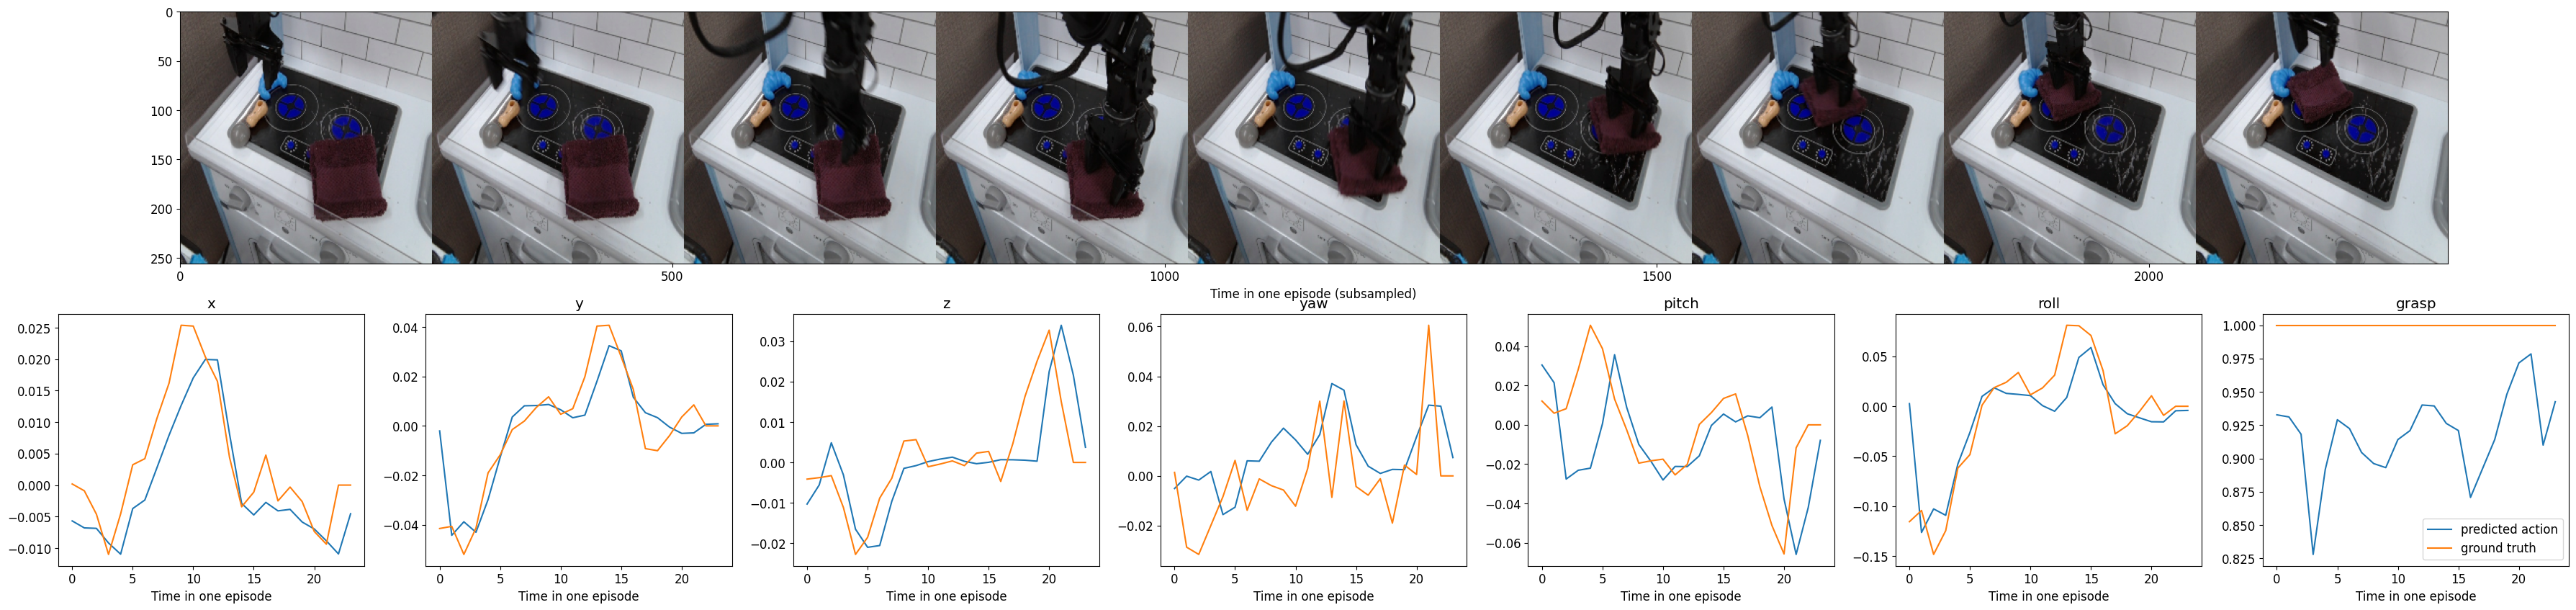

In [30]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
print(pred_actions.shape)
print(true_actions.shape)
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()